In [1]:
%matplotlib inline
%reload_ext Cython
from __future__ import print_function
font = {'family' : 'sans-serif',
        'style': 'normal',
        'weight' : 'medium',
        'size' : 8}
import matplotlib
matplotlib.rc('font', **font)
import os
import time
import pylab
import numpy as np
from numpy import int16, uint16, uint8, float16, log2
import pickle
import glob

import cv2
from cv2 import cvtColor as convertColor, COLOR_BGR2GRAY, COLOR_GRAY2RGB,\
                resize, imread, imwrite

import pyximport; pyximport.install()

from pydvs.decode_spikes import *
# from pydvs.generate_spikes import *


def decode_aedat(fname, imgw):
    f = open(fname, 'rb')
    l = '#'
    while True:
        l = f.readline()
#         print(l)
        if l[:35] == '#End of Preferences for this AEChip':
            break
    
    
    addr_time = np.fromstring(f.read(), dtype='>u4')
    print(addr_time.shape)
    addr_time = np.transpose(np.reshape(addr_time,(addr_time.size/2 , 2)))
    
    xmask = 254 #hex2dec ('fE')  x are 7 bits (64 cols) ranging from bit 1-7
    ymask = 32512 #hex2dec ('7f00')  y are also 7 bits ranging from bit 8 to 14.
    xshift=1 # bits to shift x to right
    yshift=8 # bits to shift y to right
    polmask=1 # polarity bit is LSB

    cols = ((addr_time[0, :] & xmask) >> xshift)
    rows = (addr_time[0, :] & ymask) >> yshift
    pols = addr_time[0, :] & polmask
    
    return rows, cols, pols, addr_time[1, :]


In [2]:
fps = 60
frame_time_ms = int(1000./fps)
frame_time_us = int(1000000./fps)
imgw = 128
red = [255, 0, 0]
green = [0, 255, 0]

In [3]:
fname = './RetinaTeresa2-2016-10-10T10-49-04+0100-imse02XX-0.aedat'
rows, cols, pols, times = decode_aedat(fname, imgw)

(2760488,)


In [4]:
t0 = times[0]
print(times[0], times[-1])
print(rows[0], rows[-1])
print(cols[0], cols[-1])
print(pols[0], pols[-1])

3182596537 3251476410
75 49
15 2
1 0


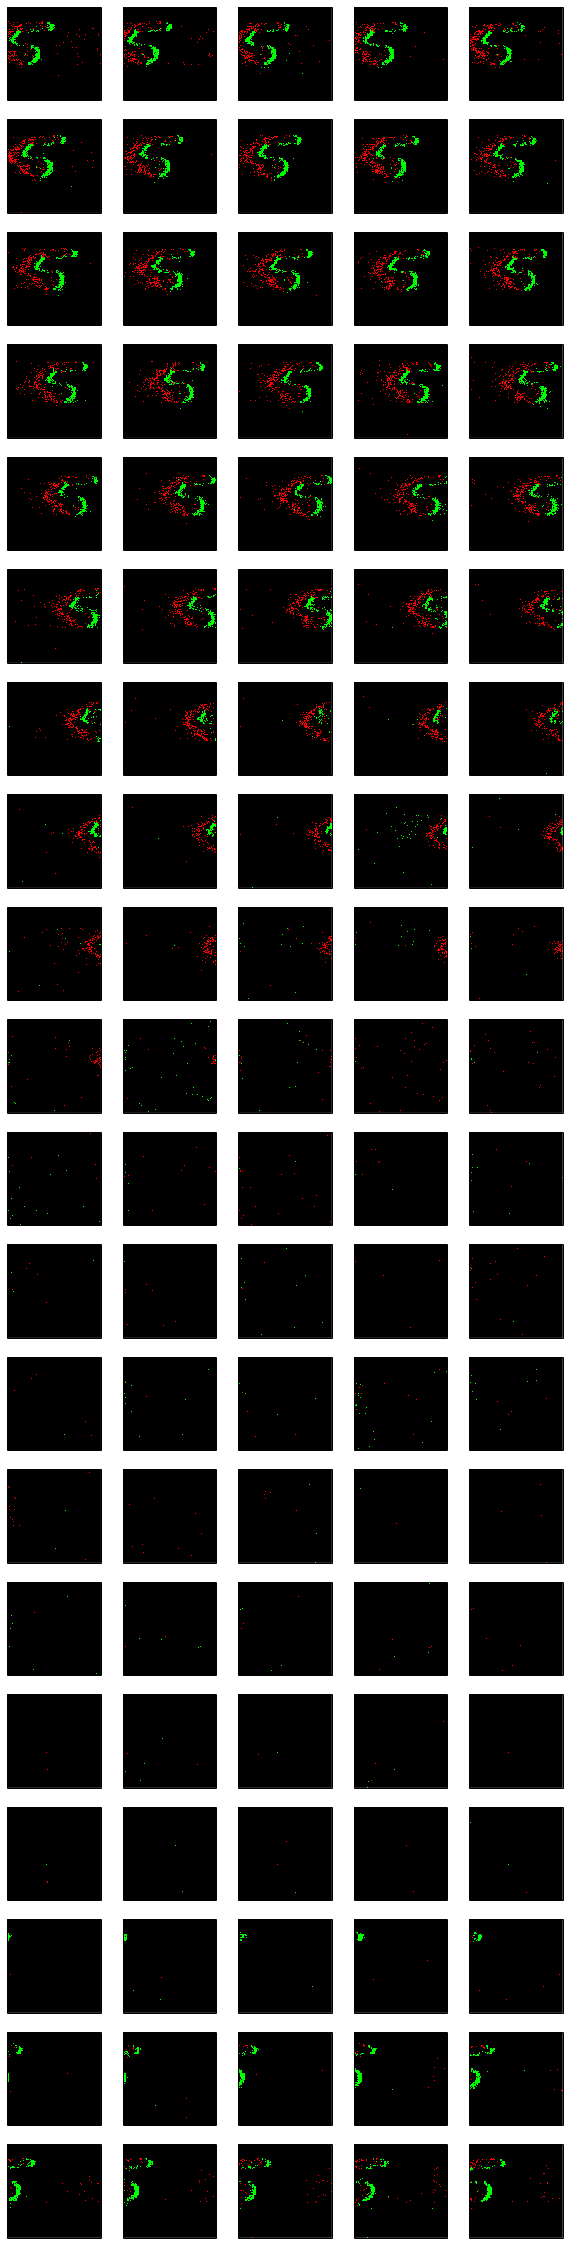

3182596537 3184263137


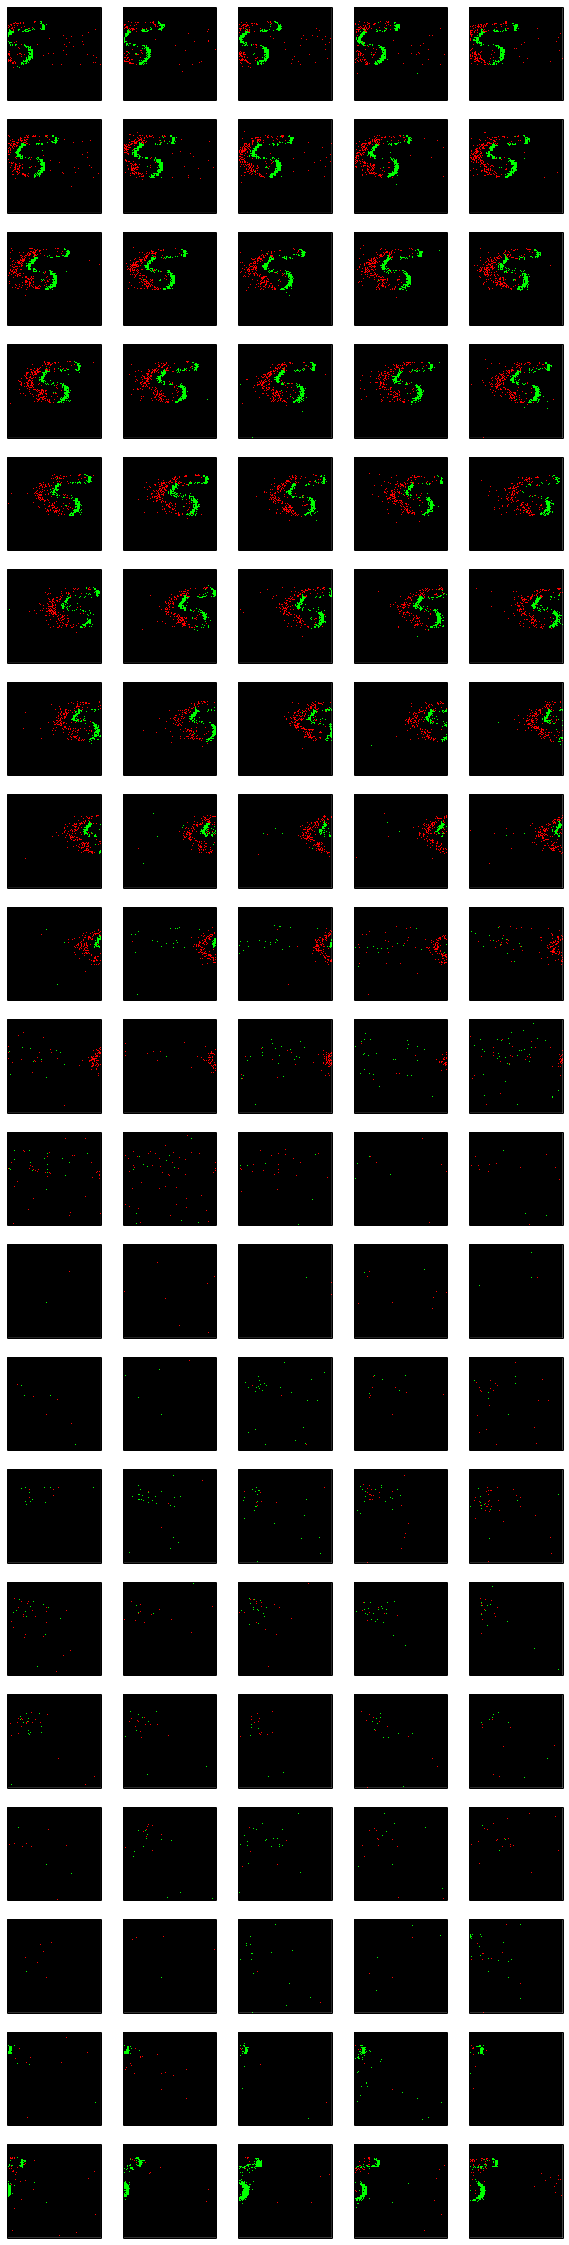

3184263137 3185929737


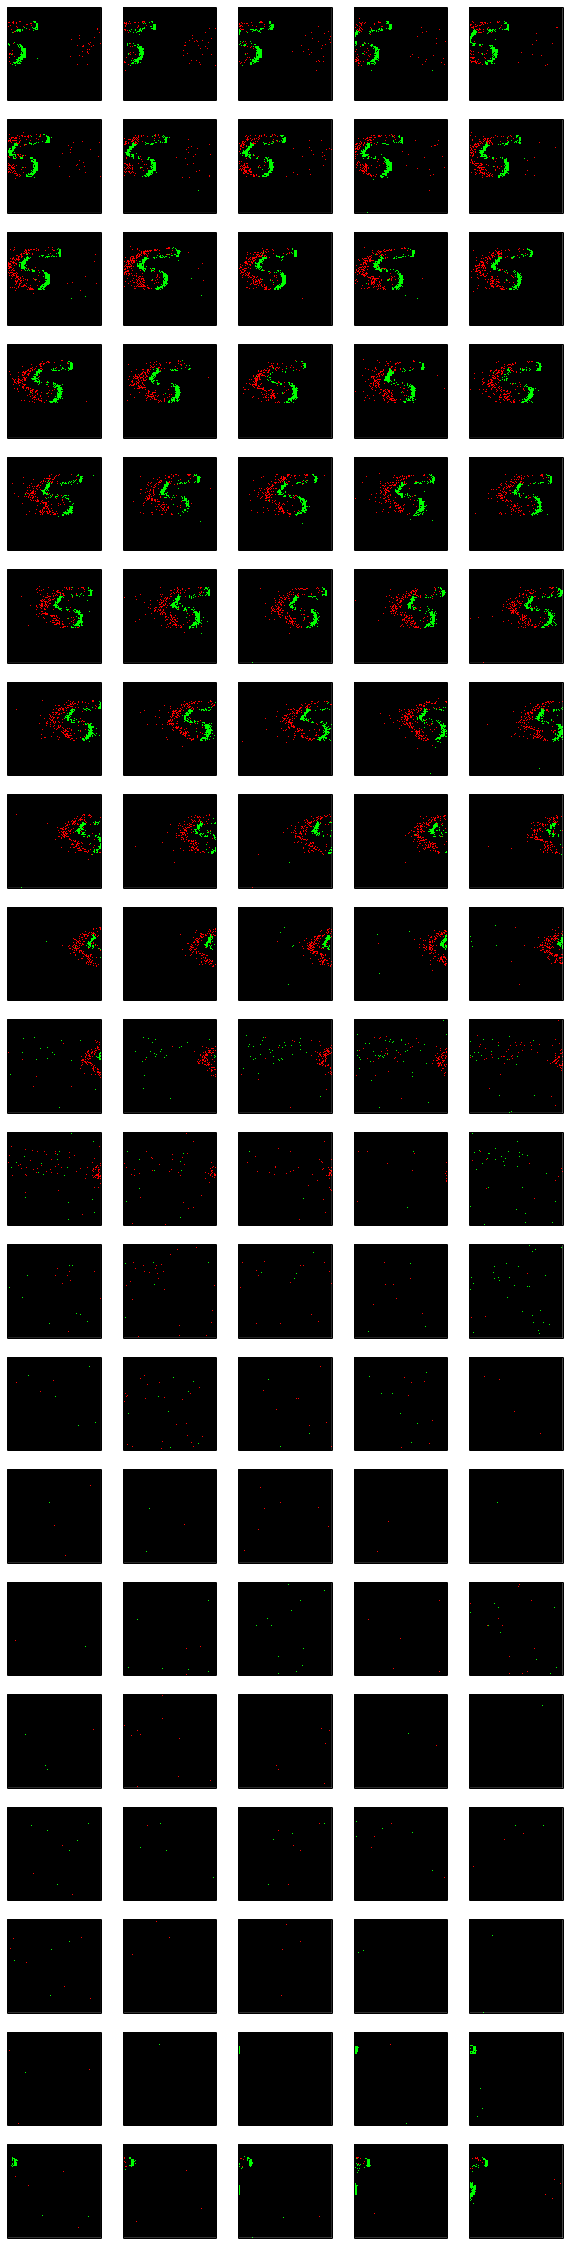

3185929737 3187596337


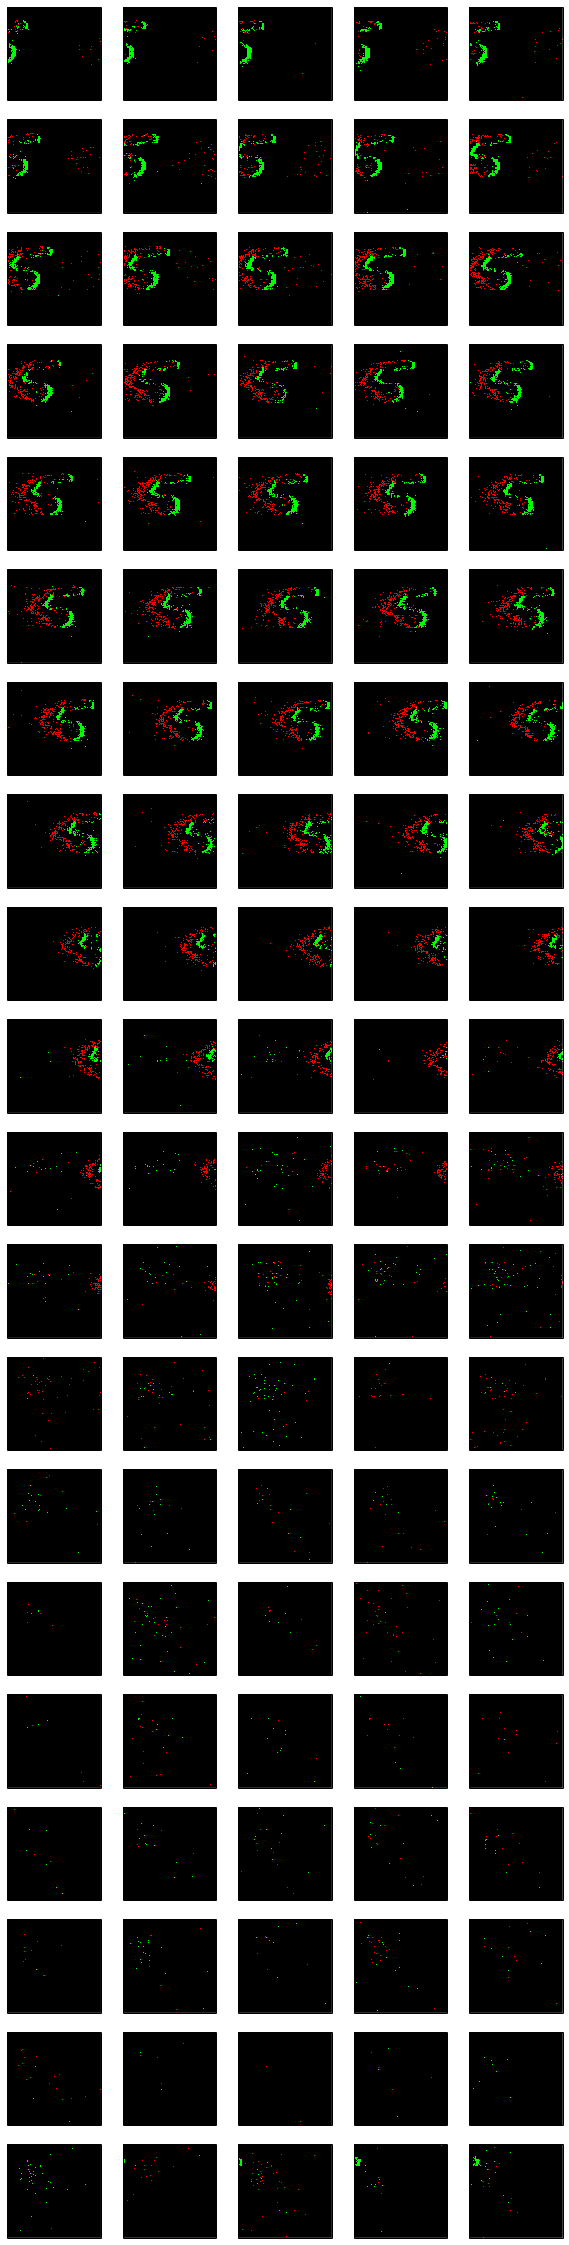

3187596337 3189262937


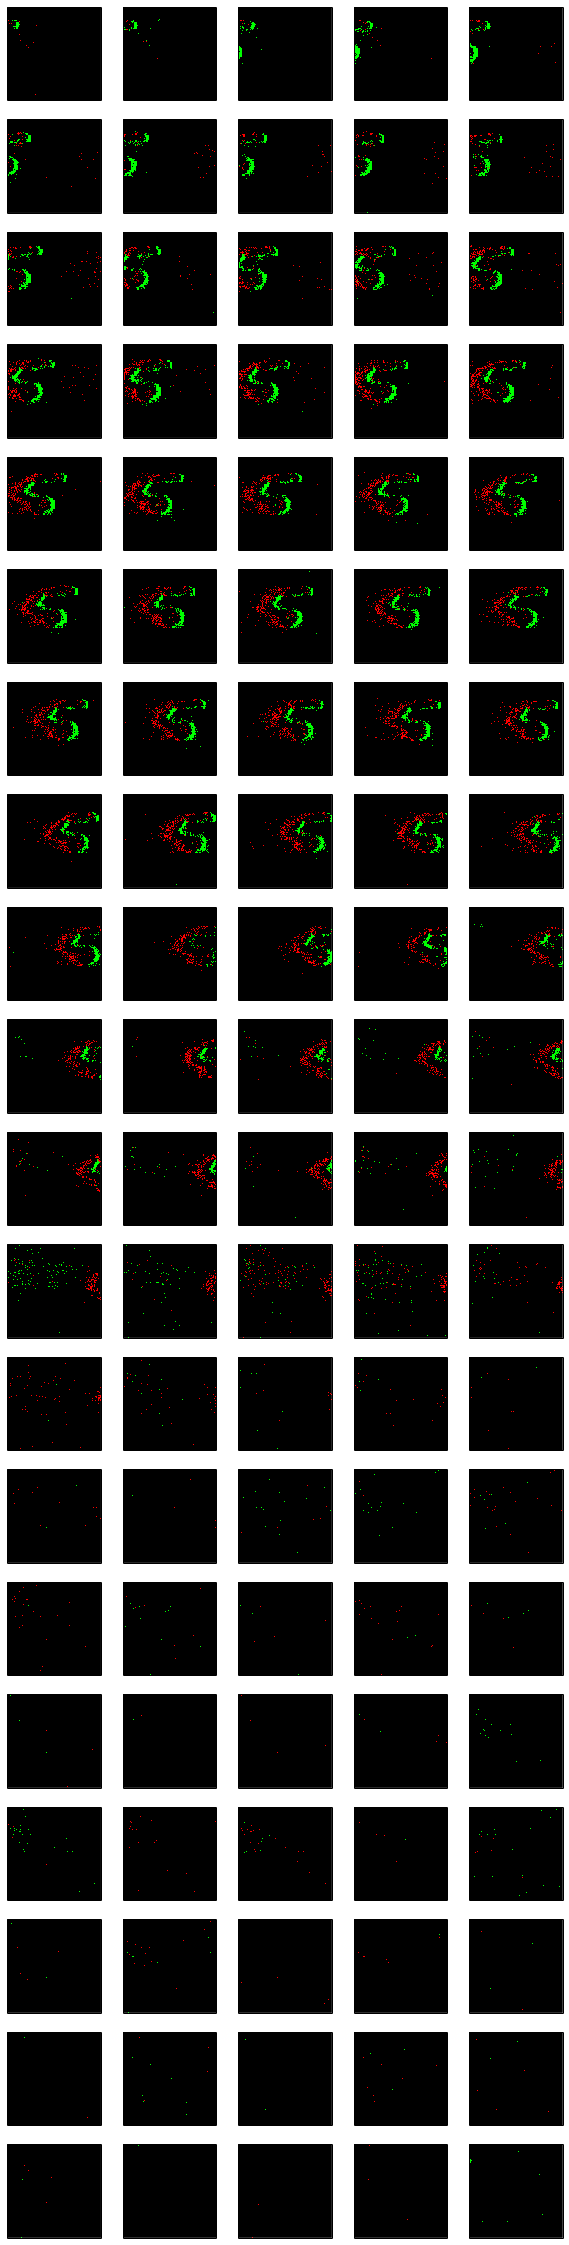

3189262937 3190929537


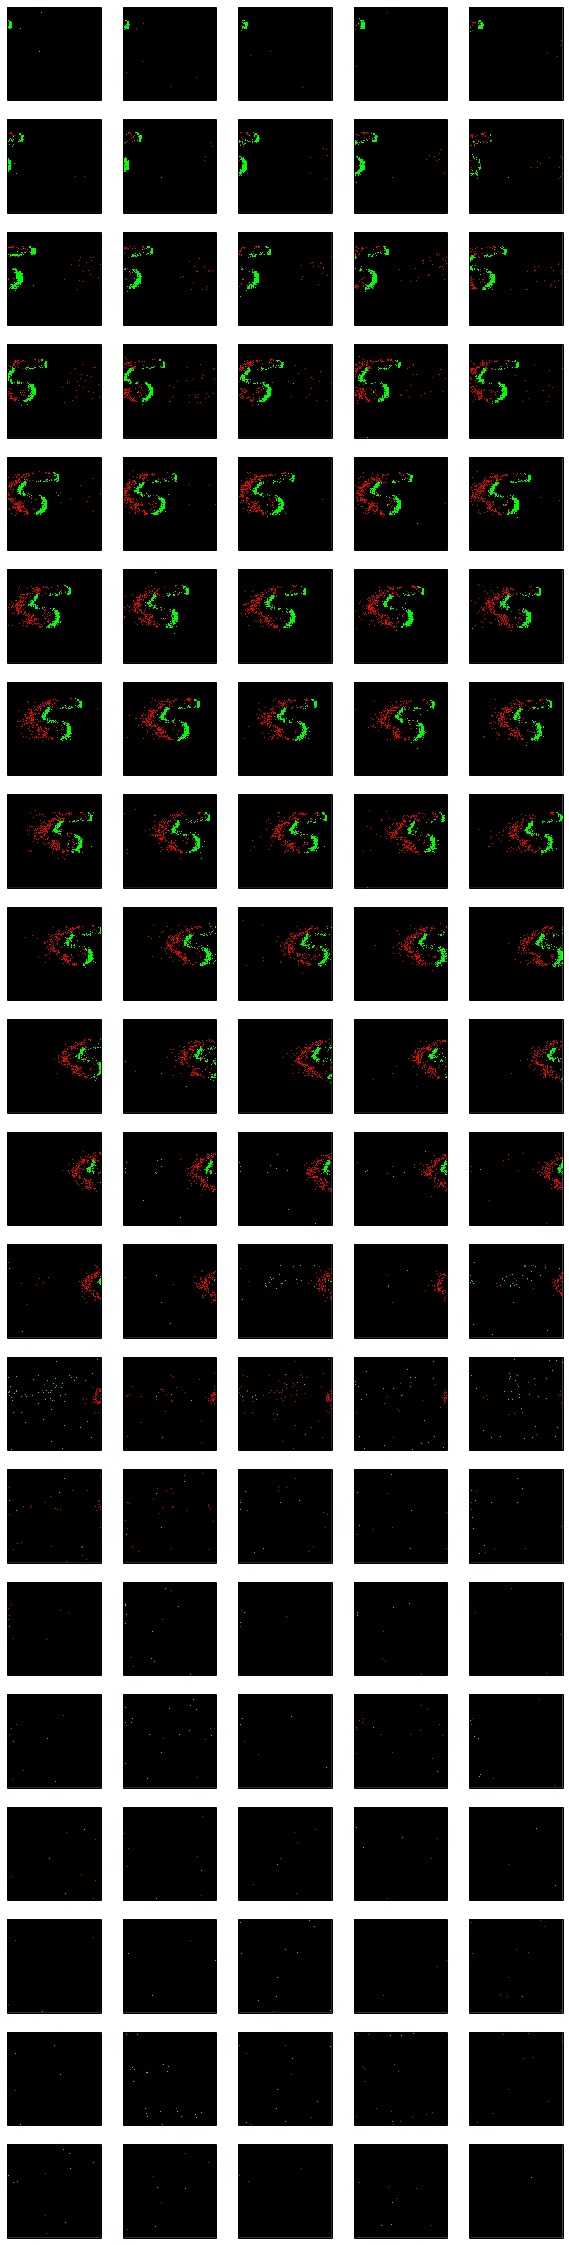

3190929537 3192596137


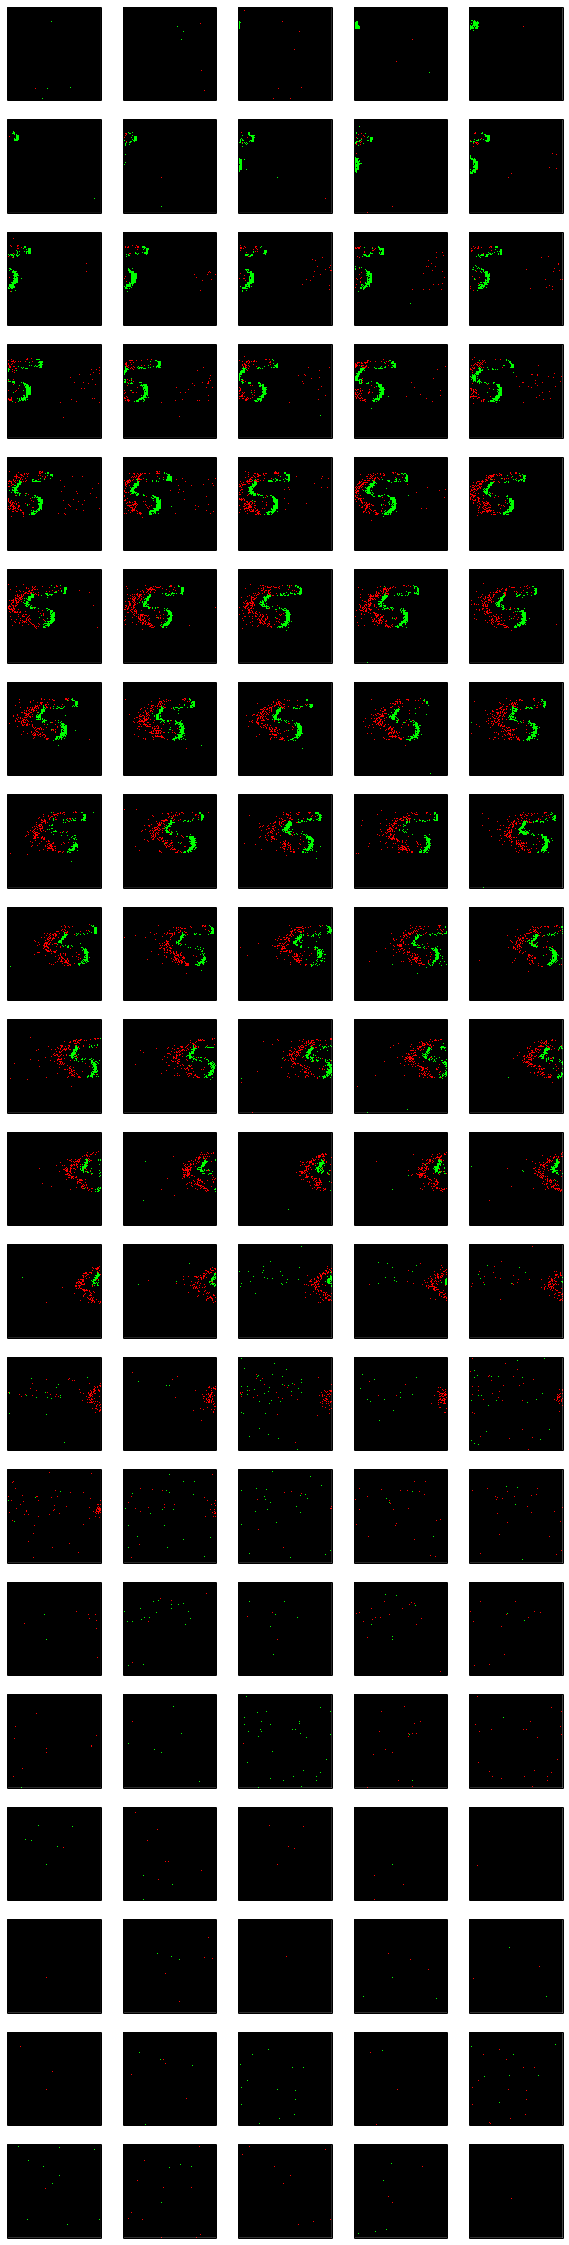

3192596137 3194262737


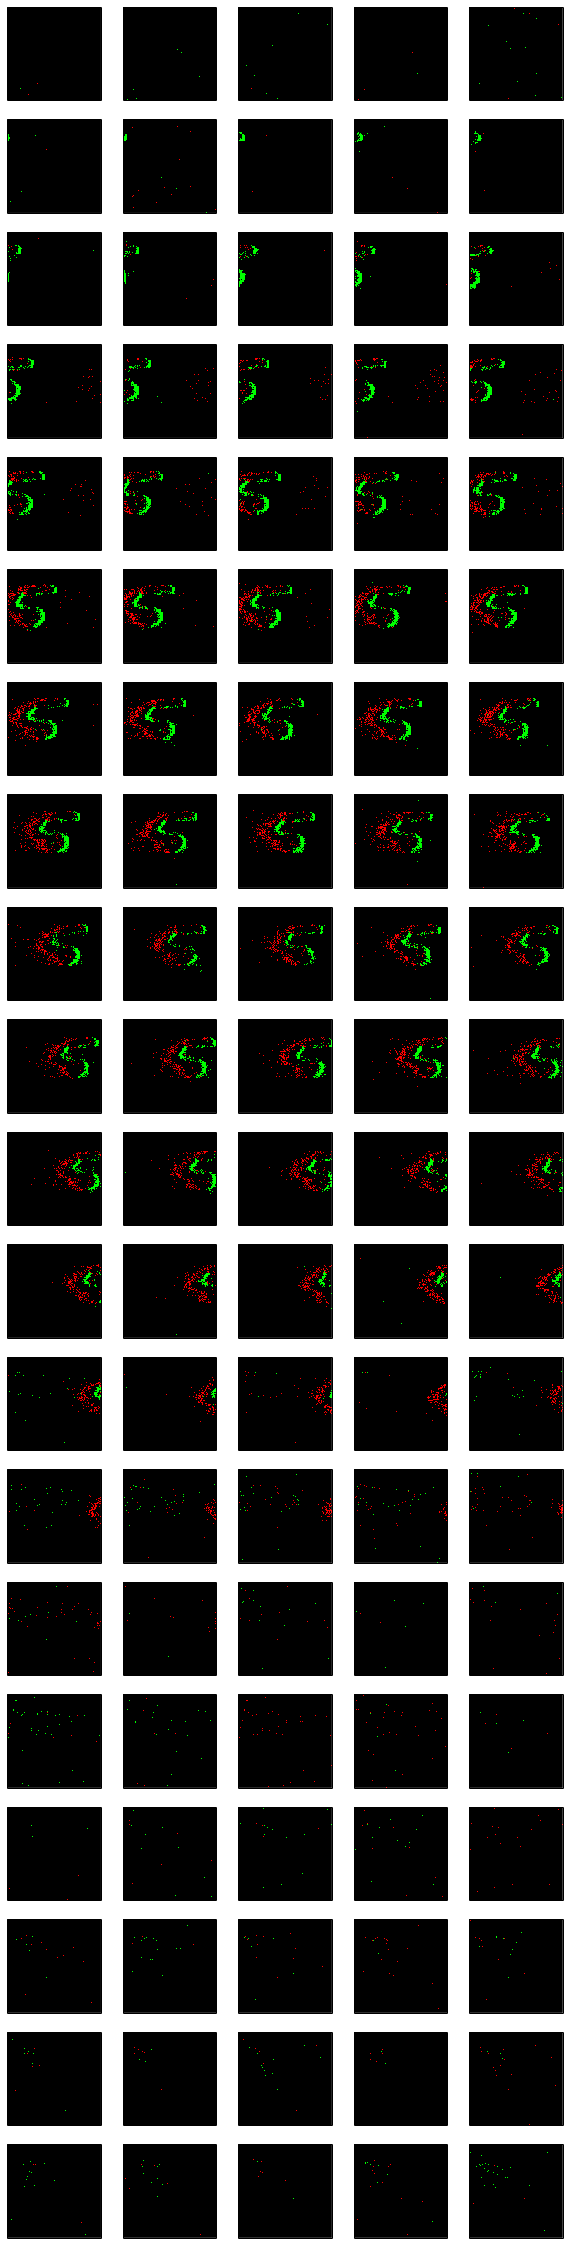

3194262737 3195929337


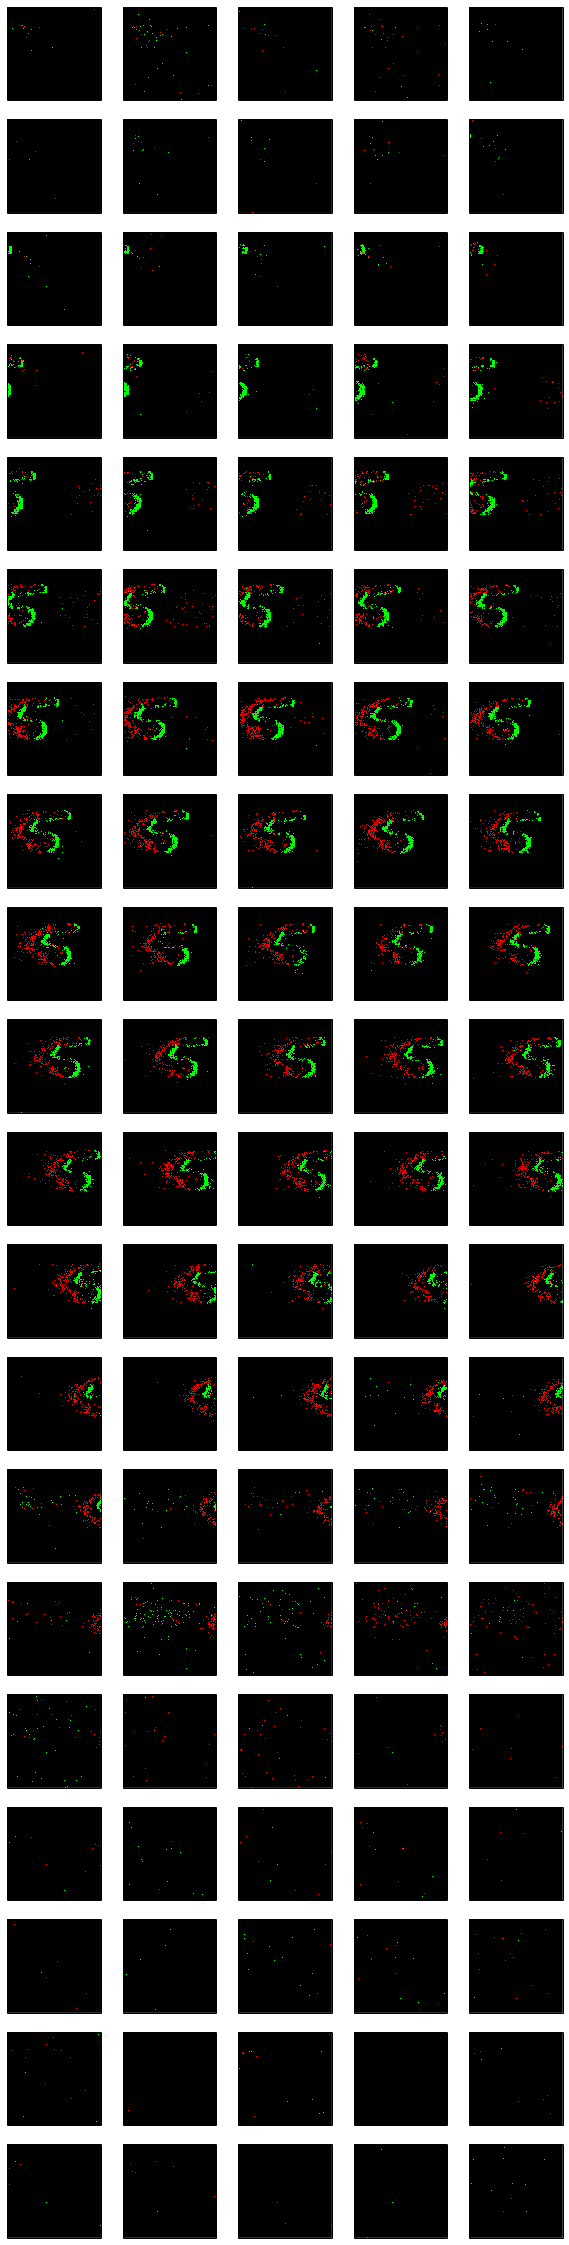

3195929337 3197595937


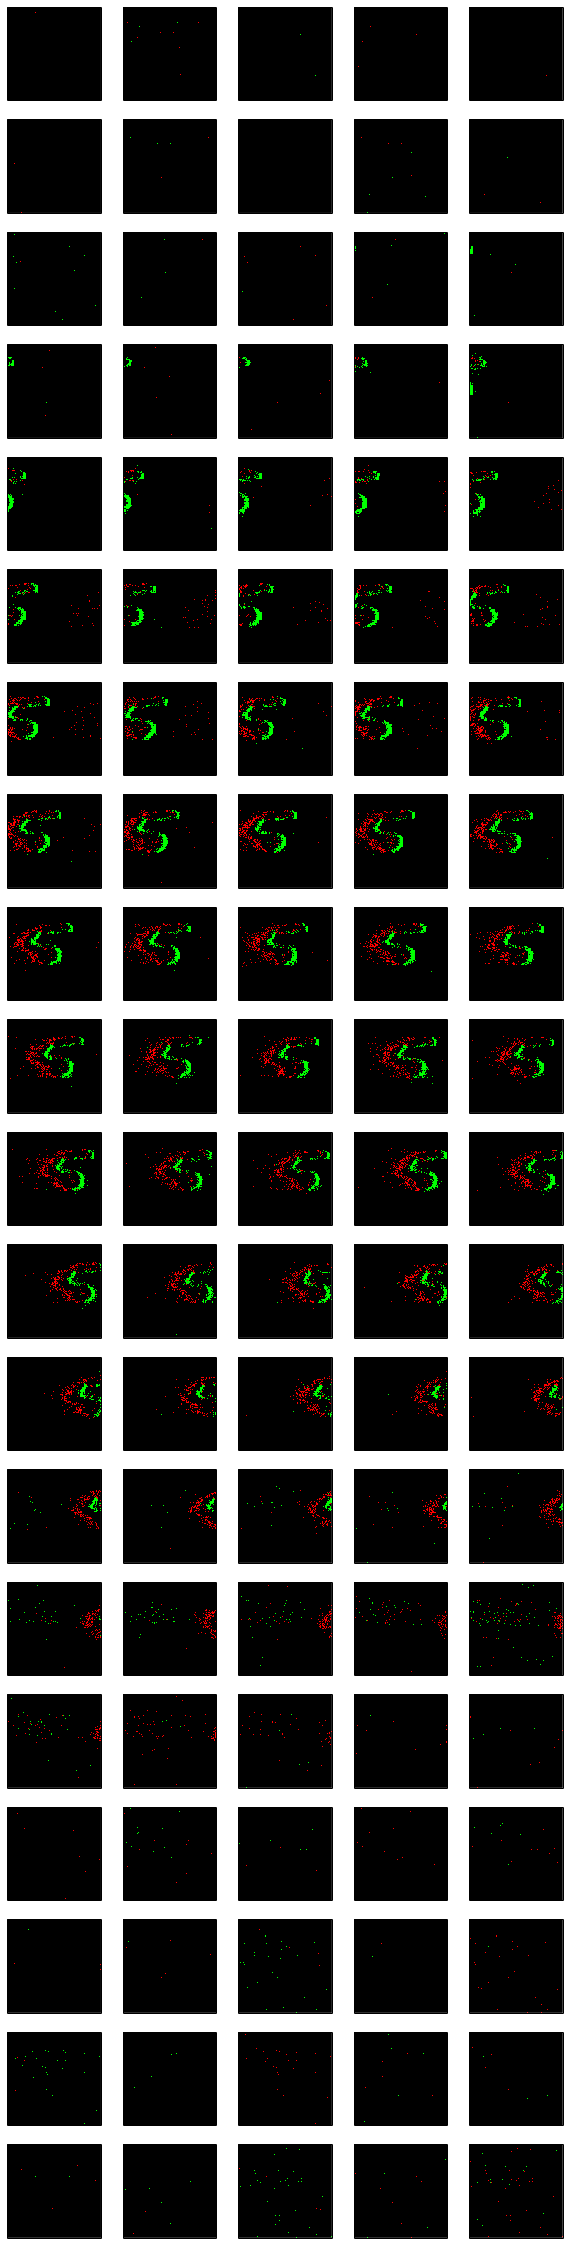

3197595937 3199262537


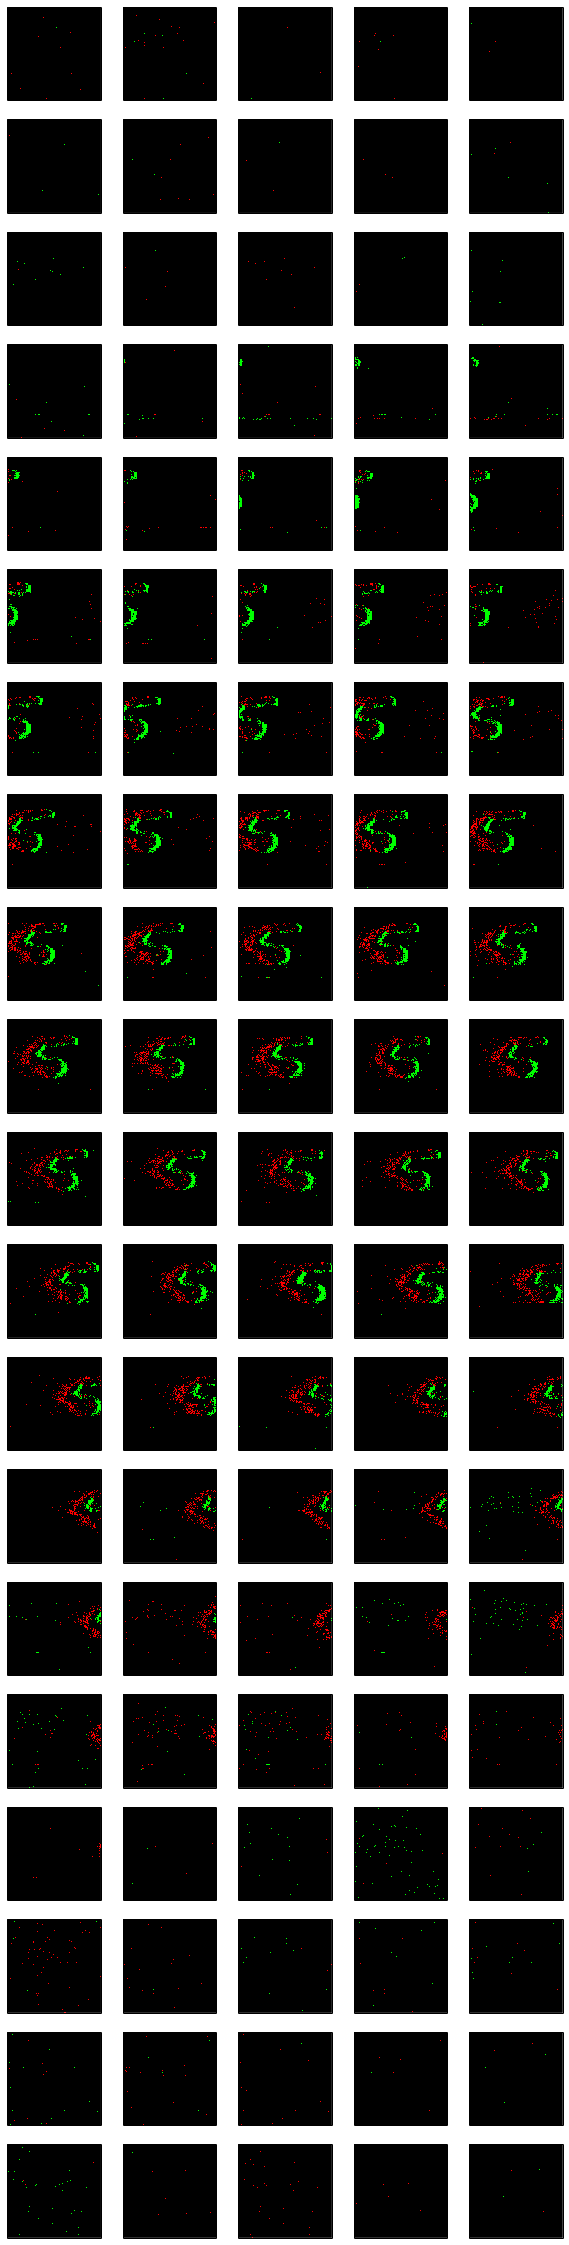

3199262537 3200929137


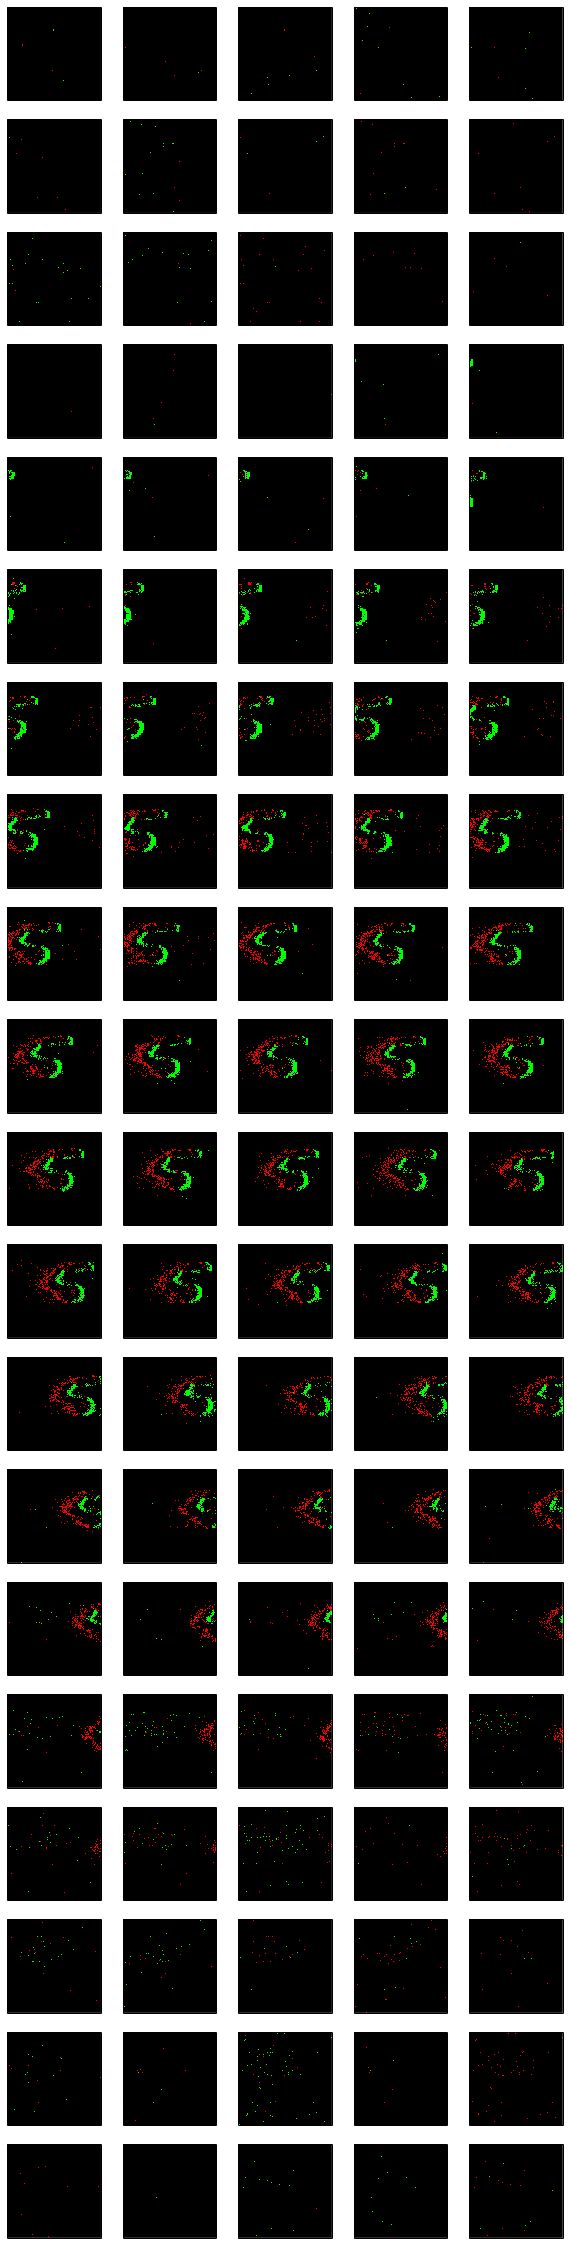

3200929137 3202595737


In [9]:
img = np.zeros((imgw, imgw, 3), dtype=np.uint8)

num_frames = 100
fcols = 5
frows = num_frames//fcols + 1
figw = 2
t0 = times[0]

spike_counts = {'up': [], 'down': []}

for j in range(12):
    fig = pylab.figure(figsize=(fcols*figw, frows*figw))
    sbi = 1
    for dt in range(t0, t0 + num_frames*frame_time_us, frame_time_us):
        to = dt + frame_time_us
        ti = np.where(np.logical_and(times >= dt, times < to))
        
        r = rows[ti]
        c = cols[ti]
        p = pols[ti]

        ur = r[np.where(p == 0)]; uc = c[np.where(p == 0)]
        dr = r[np.where(p != 0)]; dc = c[np.where(p != 0)]
        
        spike_counts['up'].append(len(ur))
        spike_counts['down'].append(len(ur))

        img[:] = 0
        img[ur, uc] = green
        img[dr, dc] = red

        ax = pylab.subplot(frows, fcols, sbi)
        sbi += 1
        ax.set_title("")
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        pylab.imshow(img.copy(), interpolation='none')
    pylab.show()
    
    print(t0, to)
    t0 = to


pickle.dump(spike_counts, open('./retina_stats.pkl', 'wb'))